In [164]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 30)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load data

In [5]:
def memory(df):
    print("Memory usage of the dataframe is {:.2f} MB".format(
        df.memory_usage().sum() / 1024**2))

In [6]:
google_drive = False
convert = False

if(google_drive):
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/we_data/train.csv')
    
elif(convert):
    df = pd.read_csv('../we_data/traina.csv')
    df.to_hdf('train.h5', 'train')
    
else:
    df = pd.read_hdf('../train.h5', 'train')

In [7]:
df['actualpayprice'] = df['payprice']/1000
df = df.fillna(0)

In [8]:
memory(df)

Memory usage of the dataframe is 500.77 MB


In [9]:
df.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,actualpayprice
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,trqRTvKaXTKfgg24JKTI,6447a7dfa30fe6eb410c91860e7c9b45,0.0,2015392487,200,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,0,0.005
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,20fc675468712705dbf5d3eda94126da,3ddf173a94bd23c326683b6373c75dd4,0.0,mm_10982364_973726_8930541,300,250,FourthView,Na,0,10722,294,23,0,2821,0,0.023
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,trqRTJn7O95I1mKYUV,625d1b5916ea925332c7b326c0574cfa,0.0,1720123646,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110",0.024
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,5F97t5E0BTK7XhNrUMpENpn,dedc488b98ca20707bc9a723957e7d1f,0.0,mm_10027070_118039_10308280,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111",0.025
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,13625cb070ffb306b425cd803c4b7ab4,4199d1227c511fc776b76594dabff9f8,0.0,1120200150,728,90,OtherView,Na,133,7330,277,133,0,2259,0,0.133


In [7]:
df.shape

(2430981, 26)

# Problem 1

In [8]:
no_click,click = df['click'].value_counts().values
print('Baseline CTR {:.5f}'.format(click/no_click))

Baseline CTR 0.00074


In [116]:
def calcluate_num_impressions(df, grouping = False):
    imp = {}
    
    if(grouping):
        imp = df.groupby(grouping).size().to_dict()
            
    else:
        imp = len(df)
    
    print(imp)
    return imp
    


def calcluate_num_clicks(df, grouping = False):
    clicks = {}
    
    if(grouping):
        for index, group in df.groupby(grouping):
            clicks[index] = np.sum(group['click'])
            
    else:
        clicks = np.sum(df['click'] == 1)
    
    print(clicks)
    return clicks
    

def calcluate_ctr(df, grouping = False):
    ctr = {}
    
    if(grouping):
        for index, group in df.groupby(grouping):
            ctr[index] = np.average(df['click'])
            
    else:
        ctr = np.average(df['click'])
    
    print(ctr)
    return ctr
    
    
def average_cost_per_mille(df, grouping = False):
    cpm = {}
    
    if(grouping):
        cpm = df.groupby('weekday').agg({'payprice': np.mean}).to_dict()['payprice']
        
    else:
        cpm = np.mean(df['payprice'])
        
    print(cpm)
    return cpm

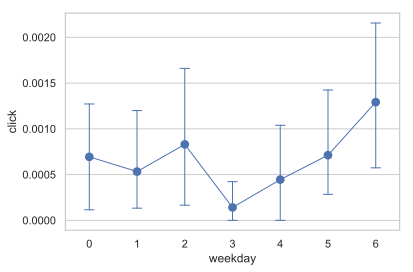

In [177]:
ax = sns.pointplot(
    x="weekday",
    y="click",
    data=df.loc[:5e4],
    estimator=np.average,
    capsize=.2)
lw = ax.lines[0].get_linewidth()
plt.setp(ax.lines, linewidth=1)
plt.show()

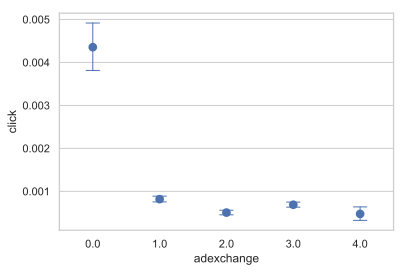

In [328]:
ax = sns.pointplot(
    x="adexchange",
    y="click",
    data=df,
    estimator=np.average,
    capsize=.2,
    join=False)
lw = ax.lines[0].get_linewidth()
plt.setp(ax.lines, linewidth=1)
plt.show()

## 95% CI interval

In [170]:
mean = np.average(df['click'])
se = np.std(df['click'])/math.sqrt(len(df['click']))

print('[{:.5f} {:.5f}]'.format( (mean - 2 *se),  (mean + 2 *se)))

[0.00070 0.00077]


# Problem 2

# Problem 3

In [391]:
df_copy = df.copy()

## Feature engineering

In [392]:
# split user agent into os and browser
df_copy['os'], df_copy['browser'] = df_copy['useragent'].str.split('_').str

df_copy['mobieldevice'] = df_copy['useragent'].str.match(
    r'(ios)|(android)').astype(np.uint8)

df_copy['timeofday'] = pd.cut(
    df['hour'], 4, labels=["night", "morning", "afternoon", "evening"])


df_copy['weekdayhour'] = df['weekday'].astype('str') + df['hour'].astype('str')

df_copy['adsize'] = df_copy['slotwidth'] * df_copy['slotheight']

df_copy['primeestate'] = (
    (df_copy['adsize'] > 300 * 250) &
    (df_copy['slotvisibility'] == ('FirstView' or 1))).astype(np.uint8)


# convert numerical categories into strings
df_copy['weekday'] = df_copy['weekday'].astype(str)
df_copy['hour'] = df_copy['hour'].astype(str)
df_copy['region'] = df_copy['region'].astype(str)
df_copy['city'] = df_copy['city'].astype(str)
df_copy['adexchange'] = df_copy['adexchange'].astype(str)

## Remove columns

In [374]:
# drop colums unavalible in test data
df_copy = df_copy.drop(columns=['bidprice', 'payprice', 'actualpayprice'])

# unqiue or no information
df_copy = df_copy.drop(columns=['urlid', 'bidid'])

# remove some very sparse fields to reduce featuers
df_copy = df_copy.drop(columns=['userid', 'url', 'domain', 'slotid', 'IP'])

In [368]:
a, b = df_copy.query('mobieldevice == 1')['click'].value_counts()
print(b/a)

0.004655004129439147


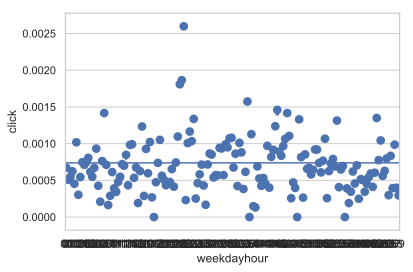

In [393]:
a, b = df_copy['click'].value_counts()

sns.pointplot(
    x="weekdayhour",
    y="click",
    data=df_copy,
    estimator=np.average,
    capsize=.2,
    join=False,
    ci=False)
lw = ax.lines[0].get_linewidth()
plt.setp(ax.lines, linewidth=1)
plt.axhline(b/a)
plt.show()

In [ ]:
a, b = df_copy['click'].value_counts()

sns.pointplot(
    x="mobieldevice",
    y="click",
    data=df_copy,
    estimator=np.average,
    capsize=.2,
    join=False,
    ci=False)
lw = ax.lines[0].get_linewidth()
plt.setp(ax.lines, linewidth=1)
plt.axhline(b/a)
plt.show()

In [ ]:
# converting all fields to str is a quick hack for one hot encoding to work properly
for column in df_copy.columns:
    if (column == 'click'):
        continue
    df_copy[column] = df_copy[column].astype(str)

In [209]:
# count total features
total_features = 0
for column in df.columns:
    if (column in ['bidprice', 'payprice', 'actualpayprice', 'urlid', 'bidid']):
        continue
        
    total_features += len(df[column].unique())
    
print(total_features)

4430921


In [196]:
no_click, click = df_copy['click'].value_counts()

## Binary encode the user tags

In [188]:
mlb = MultiLabelBinarizer()
# mlb.fit_transform(df_copy['usertag'].str.split(','))

df_copy = df_copy.join(
    pd.DataFrame(
        mlb.fit_transform(df_copy['usertag'].str.split(',')),
        columns='usertag_' + mlb.classes_,
        index=df_copy.index))
df_copy = df_copy.drop(columns='usertag')

In [190]:
mlb.classes_

array(['0', '10006', '10024', '10031', '10048', '10052', '10057', '10059',
       '10063', '10067', '10074', '10075', '10076', '10077', '10079',
       '10083', '10093', '10102', '10110', '10111', '10114', '10115',
       '10116', '10117', '10118', '10120', '10123', '10125', '10126',
       '10127', '10129', '10130', '10131', '10133', '10138', '10140',
       '10142', '10145', '10146', '10147', '10148', '10149', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632',
       '11680', '11724', '11944', '13042', '13403', '13496', '13678',
       '13776', '13800', '13866', '13874', '14273', '15398', '16593',
       '16617', '16661', '16706', '16751', '16753'], dtype=object)

In [191]:
matrix = pd.get_dummies(df_copy)

In [192]:
y = matrix['click'].values
X = matrix.drop(columns='click').values

In [193]:
X.shape

(200001, 997)

In [205]:
lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr, X, y, cv=2) #error_score='f1',
print("Average accuracy: {:.3%} (+/- {:.2f})".format(scores.mean(), scores.std() * 2))

Average accuracy: 99.917% (+/- 0.00)
